In [ ]:
import argparse
import glob
import os

import numpy as np
import cv2
import imutils

from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from skimage import data, exposure

import matplotlib.pyplot as plt

import csv
import pandas as pd

ROOT_PATH = "/path/to/directory/"

# Dataset preparation

The original images are reshaped to 256x400, to reduce the data on each image by unsampling them and standarize each input size.
The dataset is stored in a new directory.

In [ ]:
for imagePath in glob.glob(f"{ROOT_PATH}/images/*"):
  imageID = imagePath[imagePath.rfind("/") + 1:]
  image = cv2.imread(imagePath)
  
  image = cv2.resize(image, (256, 400))
  cv2.imwrite(f"{ROOT_PATH}/reshapedImages/{imageID}", image)

## Color descriptor

This function creates a color descriptor for the product image. From each picture, a HSV histogram is retrieved from the center of the image (cropping part of its background).

In [ ]:
import numpy as np
import cv2
import imutils

class ColorDescriptor:
	def __init__(self):
		# store the number of bins for the 3D histogram
		self.bins = 5
		
	
	def describe(self, image):
		# convert the image to the HSV color space and initialize
		# the features used to quantify the image
		features = []
		# grab the dimensions and compute the center of the image
		im = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
		(h, w) = image.shape[:2]
		im = im[int(0.1*h):int(0.8*h) ,:]
	
		hist = self.histogram(im)
		features.extend(hist)

		# return the feature vector
		return features

	def histogram(self, image):
		# extract a 3D color histogram from the masked region of the
		# image, using the supplied number of bins per channel
		histogram = []
		
		for ch in range(0,3):
			if ch == 0:
				hist = cv2.calcHist([image[:,:,ch]], [0], None, [self.bins], [0, 180])
			else:
				hist = cv2.calcHist([image[:,:,ch]], [0], None, [self.bins], [0, 256])
			hist = (hist/sum(hist))
			histogram.extend(hist.tolist())
	 
		histogram = sum(histogram,[])
		return histogram

The descriptor is indexed in a CSV file to avoid rediscribing the pictures on each future run.

In [ ]:
# DATASET COLOR INDEXATION

import argparse
import glob

output = open(f"{ROOT_PATH}/color_index.csv", "w")
cd = ColorDescriptor()

# use glob to grab the image paths and loop over them
for imagePath in glob.glob(f"{ROOT_PATH}/images/*"):
	# extract the image ID (i.e. the unique filename) from the image
	# path and load the image itself
	imageID = imagePath[imagePath.rfind("/") + 1:]
	image = cv2.imread(imagePath)
	# describe the image
	features = cd.describe(image)
	# write the features to file
	features = [str(f) for f in features]
	output.write("%s,%s\n" % (imageID, ",".join(features)))
# close the index file
output.close()

## Gradient descriptor

This function creates a gradient descriptor for the product image. Product's shapes are described using Histograms of Gradient (HOG) in the Saturation (S) and Value (V) channels. The Hue (H) channel was removed because it contained redundant information. Again, the image background is cropped.

In [ ]:
from skimage.feature import hog
from skimage import data, exposure

class GradientDescriptor:

	def describe(self, image):
		# convert the image to the HSV color space and initialize
		# the features used to quantify the image
		features = []
		# grab the dimensions and compute the center of the image
		im = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
		(h, w) = image.shape[:2]
		im = im[int(0.1*h):int(0.8*h) ,:]

		hist = self.getHOG(im)
		features.extend(hist)
		# return the feature vector
		return features

	def getHOG(self, image):
		# extract a 3D color histogram from the masked region of the
		# image, using the supplied number of bins per channel
		hog_list = []

		for ch in range(1,3):
			fd = hog(image[:,:,ch], orientations=8, pixels_per_cell=(32, 32),cells_per_block=(1, 1), visualize=False )
			hog_list.extend(fd.tolist())
		return hog_list

The descriptor is indexed in a CSV file to avoid rediscribing the pictures on each future run.

In [ ]:
# DATASET GRADIENT INDEXATION

output = open(f"{ROOT_PATH}/hog32_index.csv", "w")
gd = GradientDescriptor()

# use glob to grab the image paths and loop over them
for imagePath in glob.glob(f"{ROOT_PATH}/images/*"):
    # extract the image ID (i.e. the unique filename) from the image
    # path and load the image itself
    imageID = imagePath[imagePath.rfind("/") + 1:]
    image = cv2.imread(imagePath)
    
    # apply hog to the image 
    features = gd.describe(image)
	  
    # write the features to file
    features = [str(f) for f in features]
    output.write("%s,%s\n" % (imageID, ",".join(features)))

# close the index file
output.close()

# Ranking by image similarity

In [ ]:
class Ranker:

  def euclidean(self, d, q):
    doc = np.array(d)
    query = np.array(q)
    return np.linalg.norm(doc - query)

  def get_distance(self, query_ft, hist_type):
    header = ["name"]
    dist = []
    for i in range(1,len(query_ft)+1):
      header.append(str(i))
    
    if hist_type == "color":
      df_index = pd.read_csv(f"{ROOT_PATH}/color_index.csv", names=header, header=None, index_col=False)
    else:
      df_index = pd.read_csv(f"{ROOT_PATH}/hog32_index.csv", names=header, header=None, index_col=False)
    
    for i in range(0,df_index.shape[0]):
      doc_ft = df_index.iloc[i, 1:len(query_ft)+1]
      dist.append(self.euclidean(doc_ft, query_ft))
    
    df_index["distance"] = dist
    return df_index[["name", "distance"]]

  def get_ranking(self, im):
    q_color = ColorDescriptor().describe(im)
    q_gradient = GradientDescriptor().describe(im)

    df_color = self.get_distance(q_color, "color")
    df_gradient = self.get_distance(q_gradient, "gradient")
    
    df_rank = pd.merge(df_color, df_gradient, on="name")
    df_rank["comb_dist"] = df_rank["distance_x"]/len(q_color)) + (df_rank["distance_y"]/len(q_gradient))
    df_rank = df_rank.sort_values("comb_dist")
    
    return df_rank[0:5]

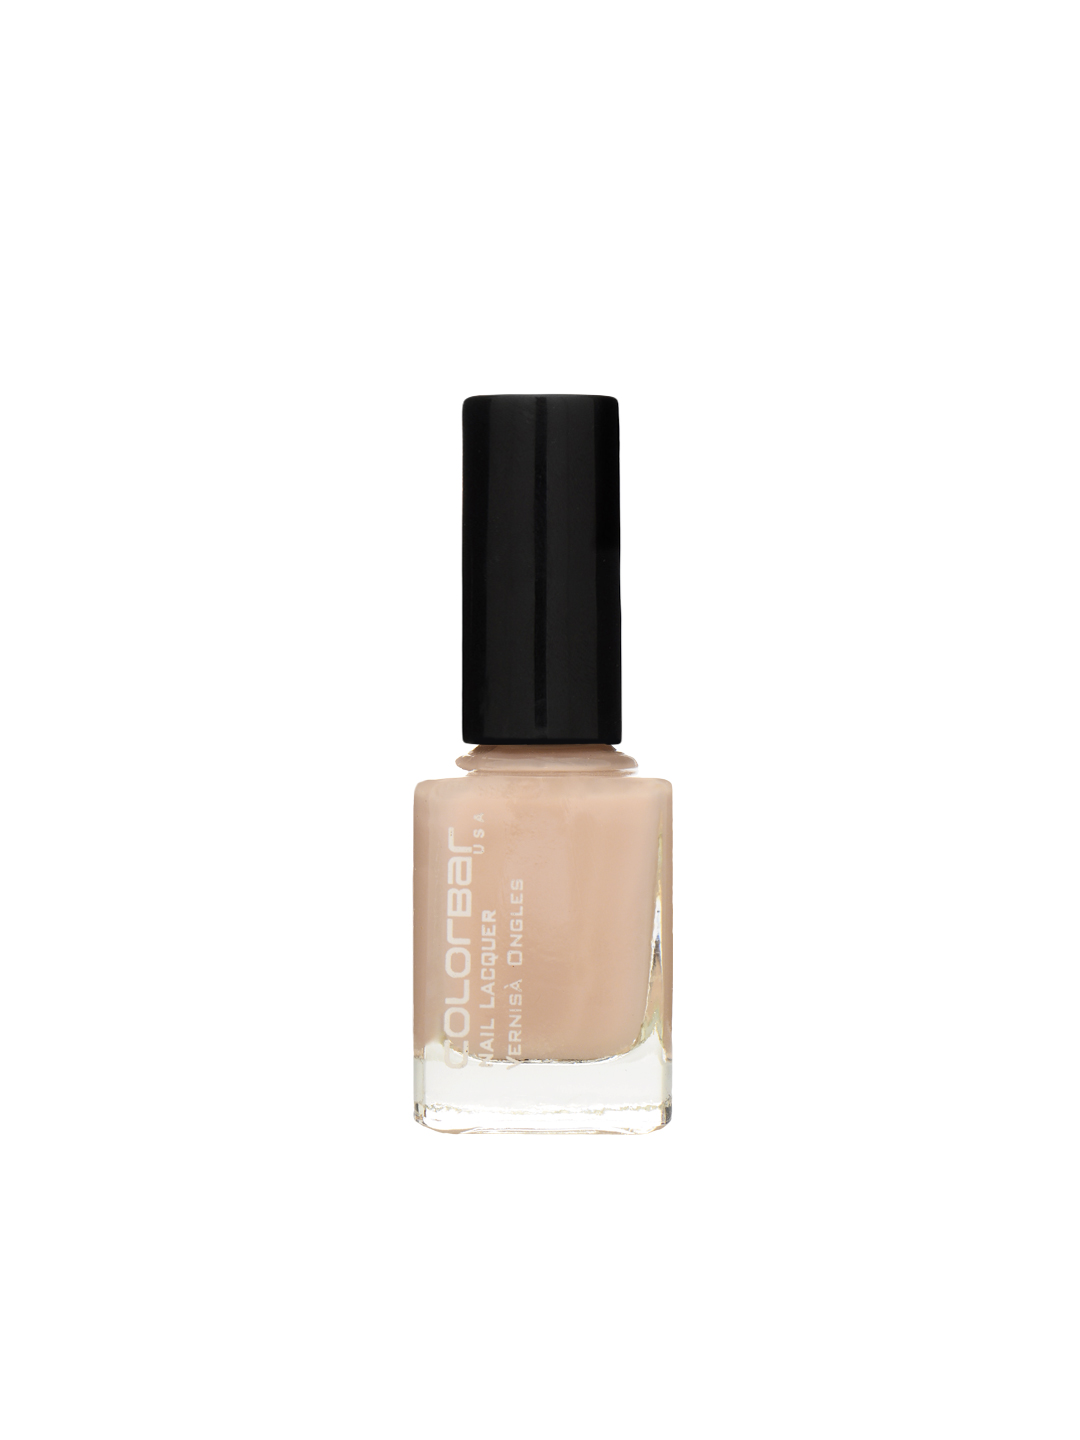

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


          name    distance_x    distance_y     comb_dist
440  55941.jpg  2.306447e-16  2.215491e-15  1.353550e-19
675  55910.jpg  9.964593e-02  1.028302e+01  6.282391e-04
159  55929.jpg  1.408712e-01  1.120563e+01  6.846061e-04
942  55936.jpg  1.385380e-01  1.271114e+01  7.765846e-04
225  44118.jpg  1.872050e-01  1.399241e+01  8.548637e-04


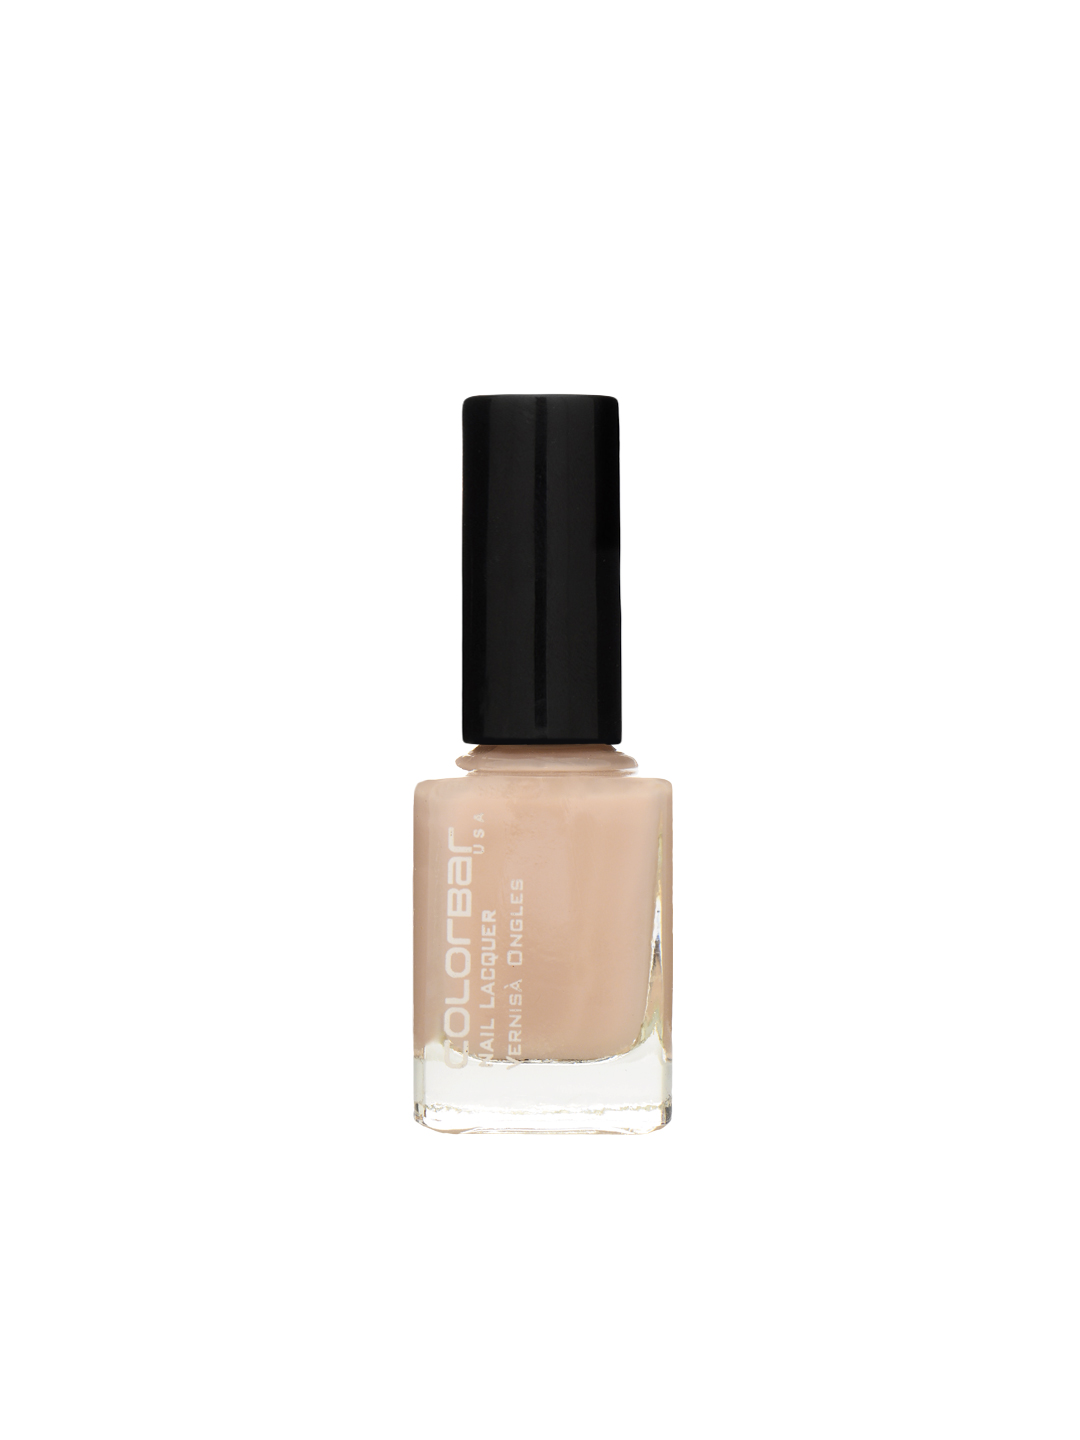

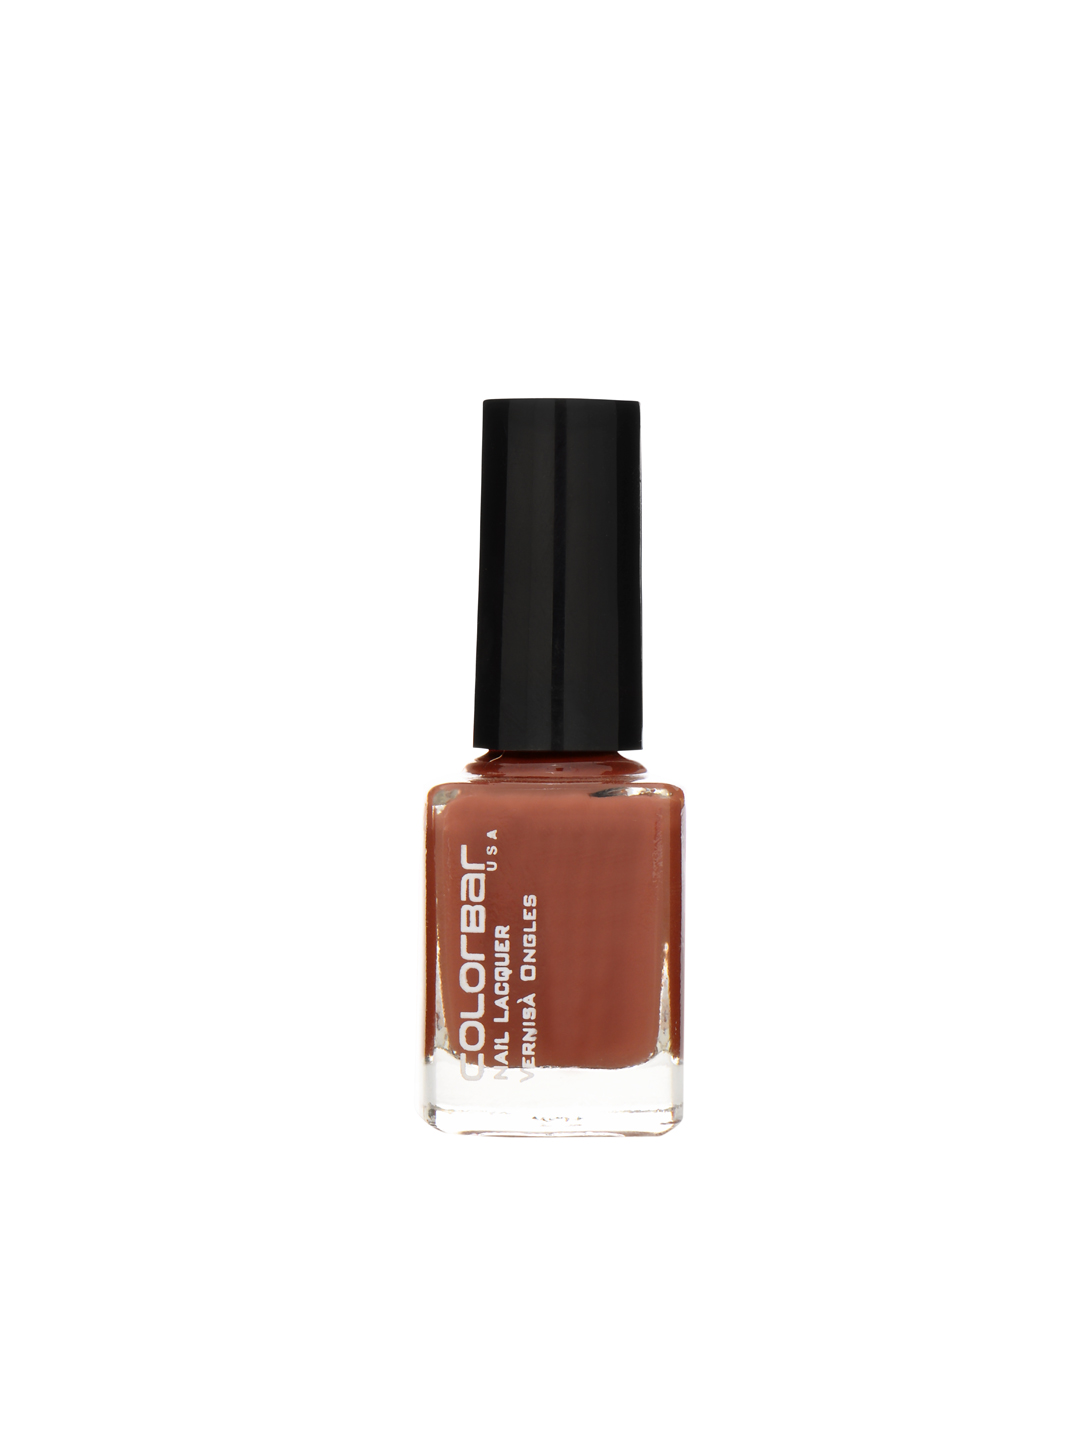

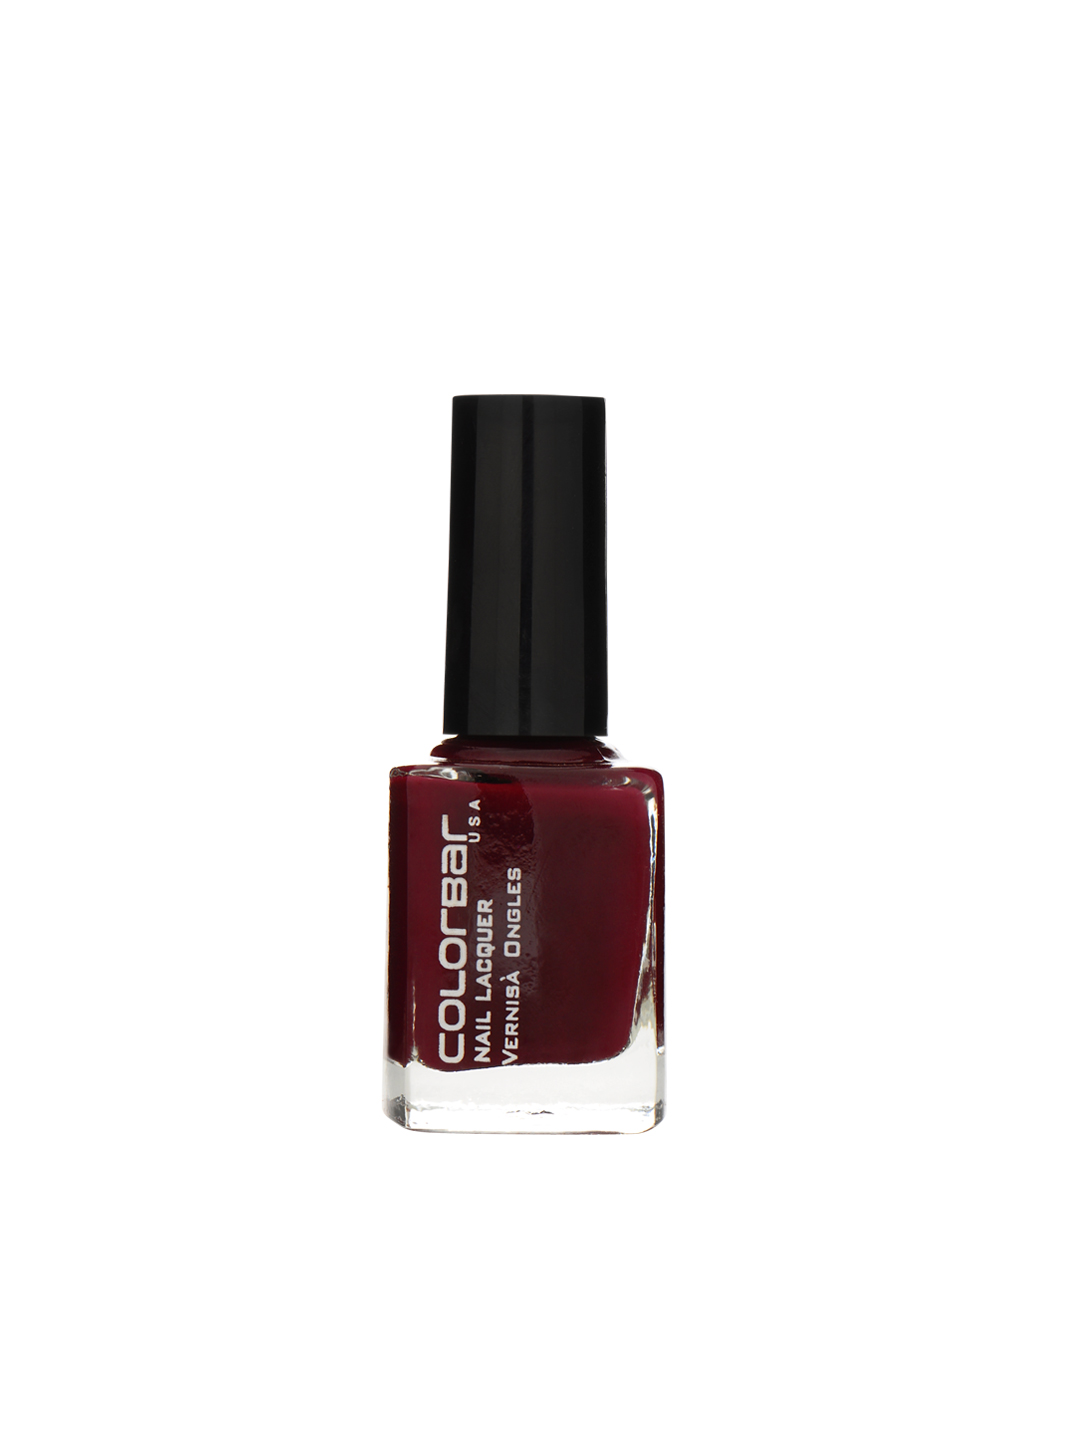

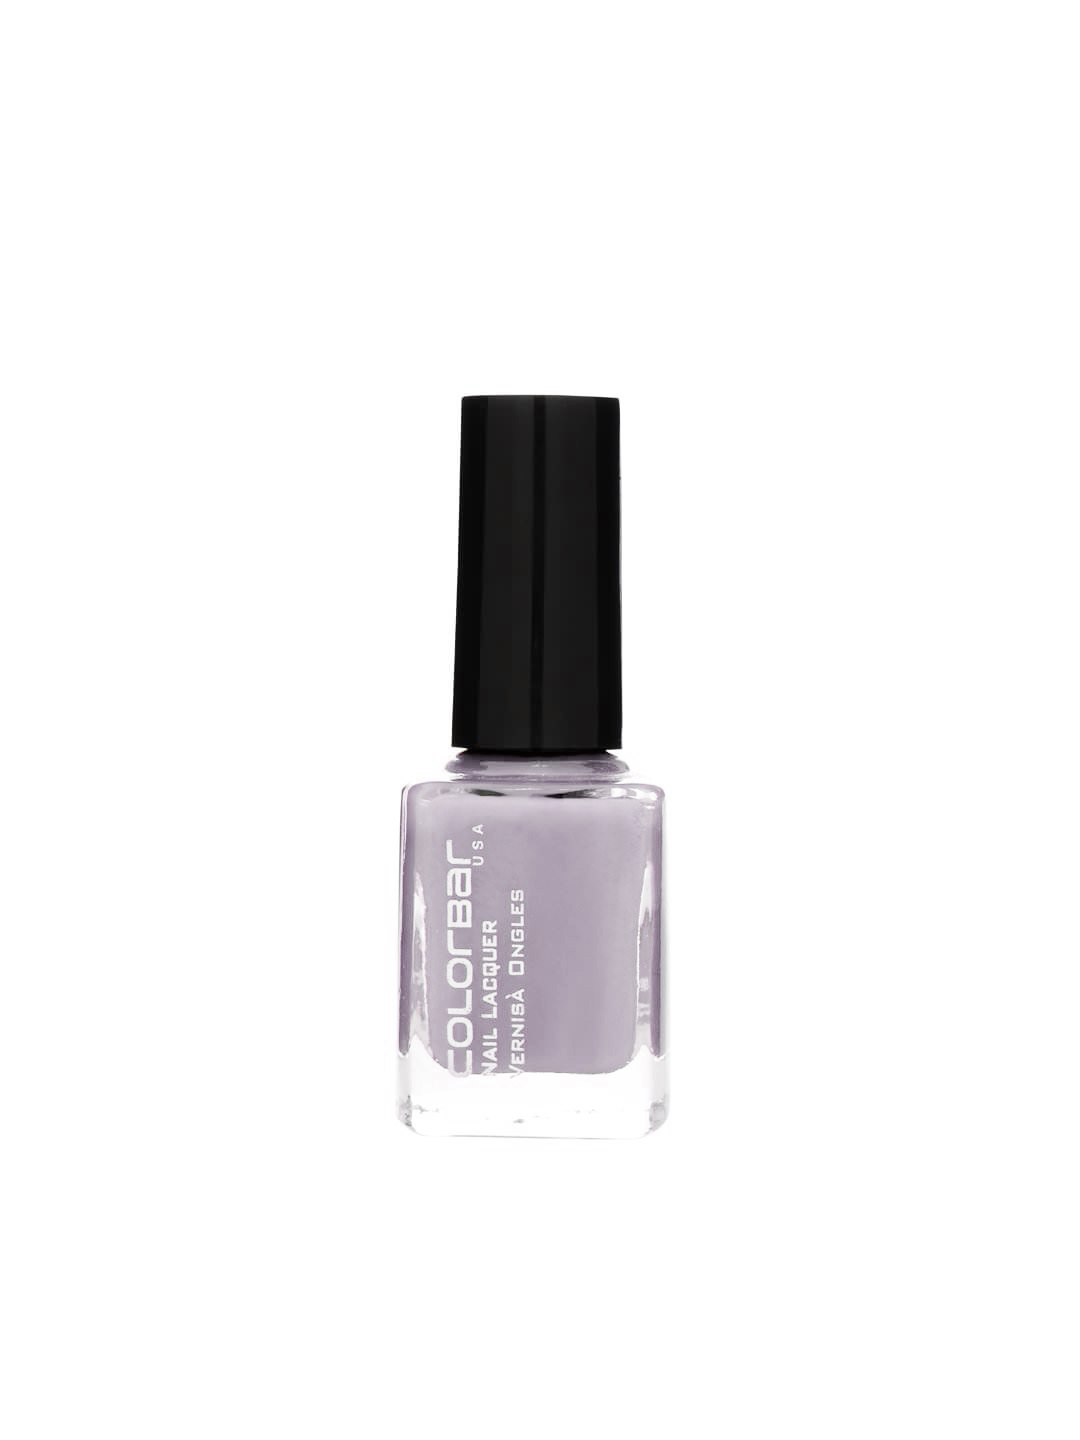

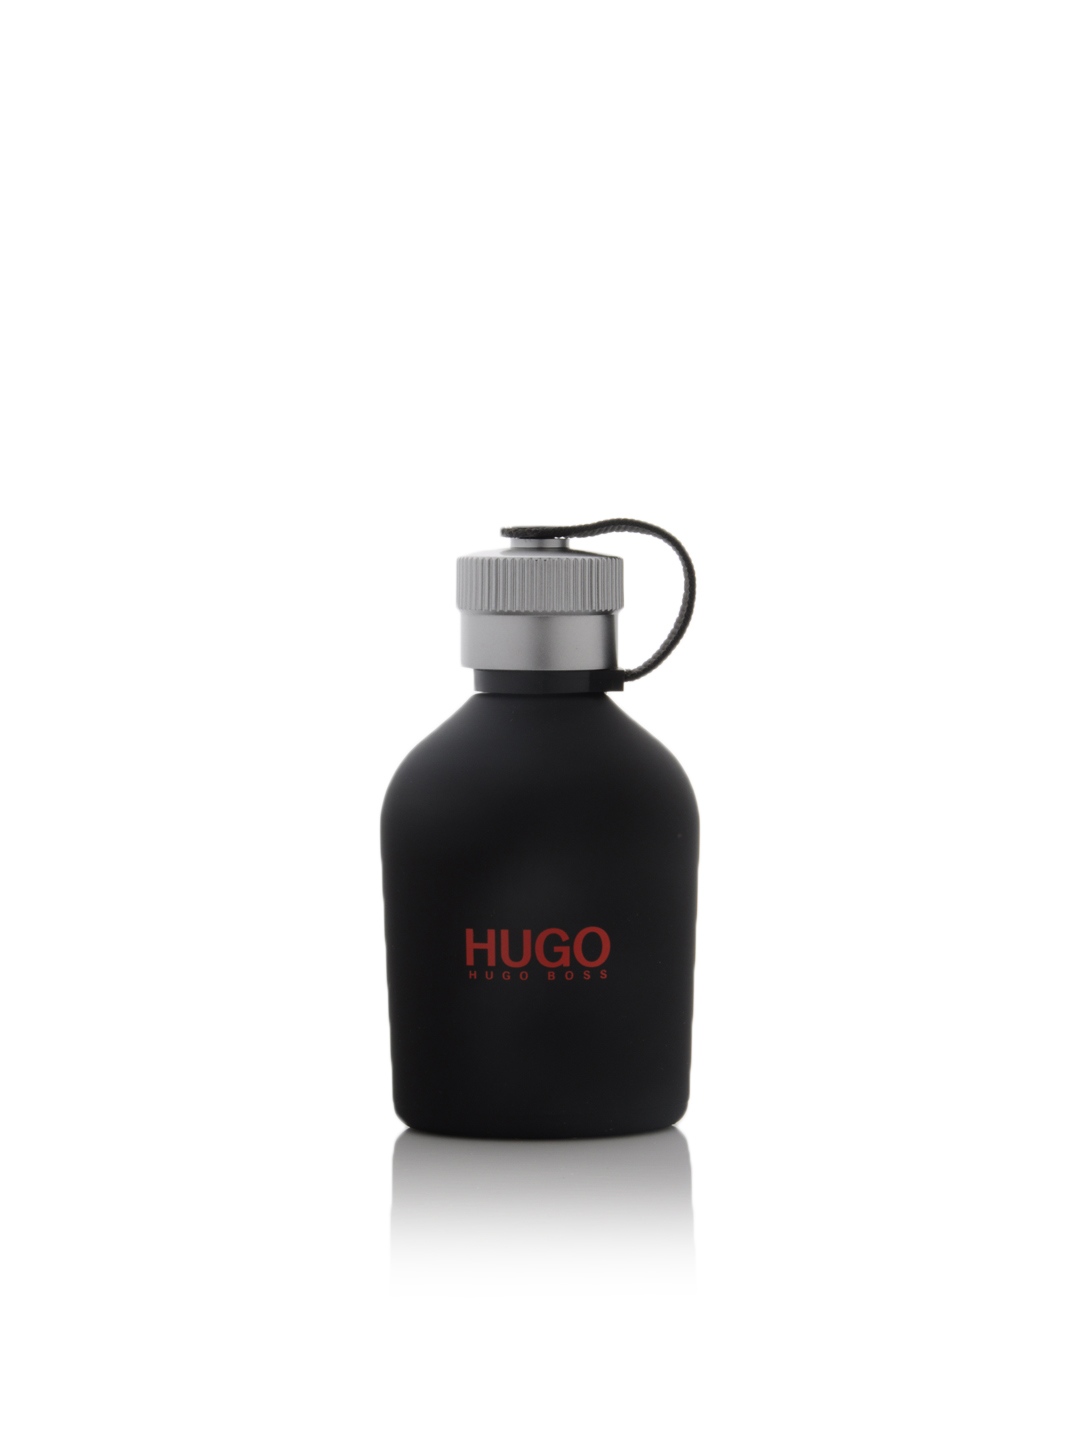

In [ ]:
from google.colab.patches import cv2_imshow

# QUERY IMAGE
im = cv2.imread(f"{ROOT_PATH}/images/55941.jpg")
cv2_imshow(im)
df_ranked = Ranker().get_ranking(im)
print(df_ranked.head())

for i in range(0,df_ranked.shape[0]):
  im_rank = cv2.imread(f"{ROOT_PATH}/images/{df_ranked.iloc[i, 0]}")
  cv2_imshow(im_rank)